# Supply Sync: Optimizing supply chain with advanced forecasting

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error, mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from itertools import product
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
!pip show statsmodels

Name: statsmodels
Version: 0.14.1
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: 
Author-email: 
License: BSD License
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, packaging, pandas, patsy, scipy
Required-by: plotnine


In [49]:
df = pd.read_csv('train.csv')
df.head()
#df_test = pd.read_csv('test.csv')

,id,date,store_nbr,family,sales,onpromotion,year,month,week_day,quarter,day
0,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,1
1,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,1
2,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,1
3,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,1
4,5,2013-01-01,1,BREAD/BAKERY,0.0,0,2013,1,1,1,1


#Data Analysis

In [50]:
df.head()
#df.columns

,id,date,store_nbr,family,sales,onpromotion,year,month,week_day,quarter,day
0,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,1
1,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,1
2,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,1
3,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,1
4,5,2013-01-01,1,BREAD/BAKERY,0.0,0,2013,1,1,1,1


In [51]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion,year,month,week_day,quarter,day
891284,1048569,2014-08-13,3,PLAYERS AND ELECTRONICS,0.000,0,2014,8,2,3,13
891285,1048570,2014-08-13,3,POULTRY,974.098,1,2014,8,2,3,13
891286,1048571,2014-08-13,3,PREPARED FOODS,324.293,0,2014,8,2,3,13
891287,1048573,2014-08-13,3,SCHOOL AND OFFICE SUPPLIES,0.000,0,2014,8,2,3,13
891288,1048574,2014-08-13,3,SEAFOOD,69.116,0,2014,8,2,3,13


In [52]:
df.shape

(891289, 11)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891289 entries, 0 to 891288
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           891289 non-null  int64  
 1   date         891289 non-null  object 
 2   store_nbr    891289 non-null  int64  
 3   family       891289 non-null  object 
 4   sales        891289 non-null  float64
 5   onpromotion  891289 non-null  int64  
 6   year         891289 non-null  int64  
 7   month        891289 non-null  int64  
 8   week_day     891289 non-null  int64  
 9   quarter      891289 non-null  int64  
 10  day          891289 non-null  int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 74.8+ MB


In [54]:
df.describe()

,id,store_nbr,sales,onpromotion,year,month,week_day,quarter,day
count,8.912890e+05,891289.000000,891289.000000,891289.000000,891289.000000,891289.000000,891289.000000,891289.000000,891289.000000
mean,5.243570e+05,27.487293,244.814461,0.116428,2013.381453,5.645368,2.998272,2.233807,15.488288
std,3.026476e+05,15.577999,805.932599,2.414316,0.485744,3.210381,2.000666,1.048978,8.801151
min,1.000000e+00,1.000000,0.000000,0.000000,2013.000000,1.000000,0.000000,1.000000,1.000000
25%,2.624200e+05,14.000000,0.000000,0.000000,2013.000000,3.000000,1.000000,1.000000,8.000000
50%,5.243480e+05,27.000000,1.000000,0.000000,2013.000000,5.000000,3.000000,2.000000,15.000000
75%,7.864810e+05,41.000000,120.600000,0.000000,2014.000000,8.000000,5.000000,3.000000,23.000000
max,1.048574e+06,54.000000,22534.000000,196.000000,2014.000000,12.000000,6.000000,4.000000,31.000000


In [55]:
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
week_day       0
quarter        0
day            0
dtype: int64

# Data cleaning

In [56]:
df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
week_day       0
quarter        0
day            0
dtype: int64

<Axes: title={'center': 'Sales Over Time In Ecuador'}>

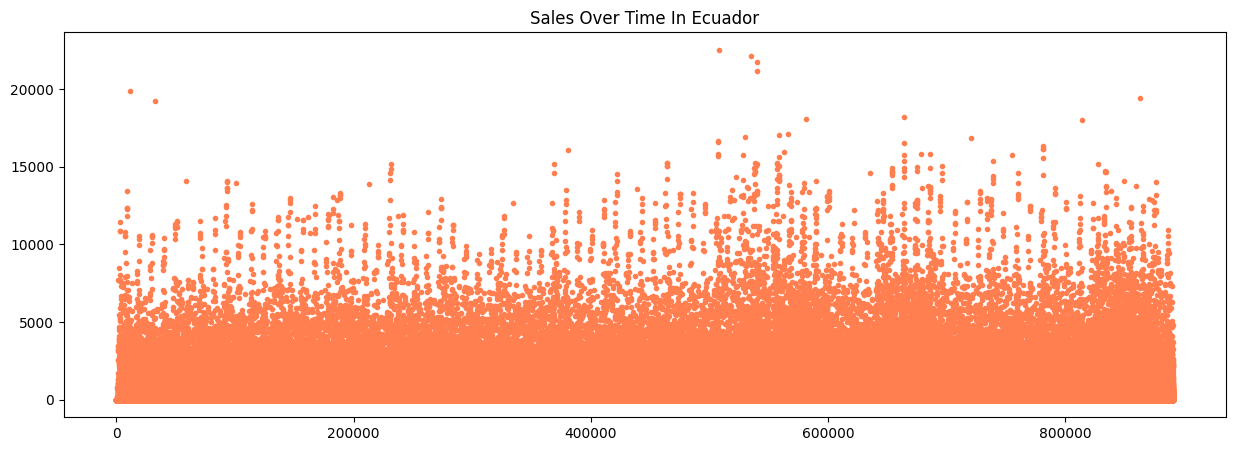

In [57]:
df['sales'].plot(style='.', figsize=(15, 5), color='coral', title='Sales Over Time In Ecuador')

In [58]:
family = set(df['family'].unique())

len(family), family

(33,
 {'AUTOMOTIVE',
  'BABY CARE',
  'BEAUTY',
  'BEVERAGES',
  'BOOKS',
  'BREAD/BAKERY',
  'CELEBRATION',
  'CLEANING',
  'DAIRY',
  'DELI',
  'EGGS',
  'FROZEN FOODS',
  'GROCERY I',
  'GROCERY II',
  'HARDWARE',
  'HOME AND KITCHEN I',
  'HOME AND KITCHEN II',
  'HOME APPLIANCES',
  'HOME CARE',
  'LADIESWEAR',
  'LAWN AND GARDEN',
  'LINGERIE',
  'LIQUOR,WINE,BEER',
  'MAGAZINES',
  'MEATS',
  'PERSONAL CARE',
  'PET SUPPLIES',
  'PLAYERS AND ELECTRONICS',
  'POULTRY',
  'PREPARED FOODS',
  'PRODUCE',
  'SCHOOL AND OFFICE SUPPLIES',
  'SEAFOOD'})

C:\Users\madhu\AppData\Local\Temp\ipykernel_25732\1464830043.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(store_nbr_data, color='coral')


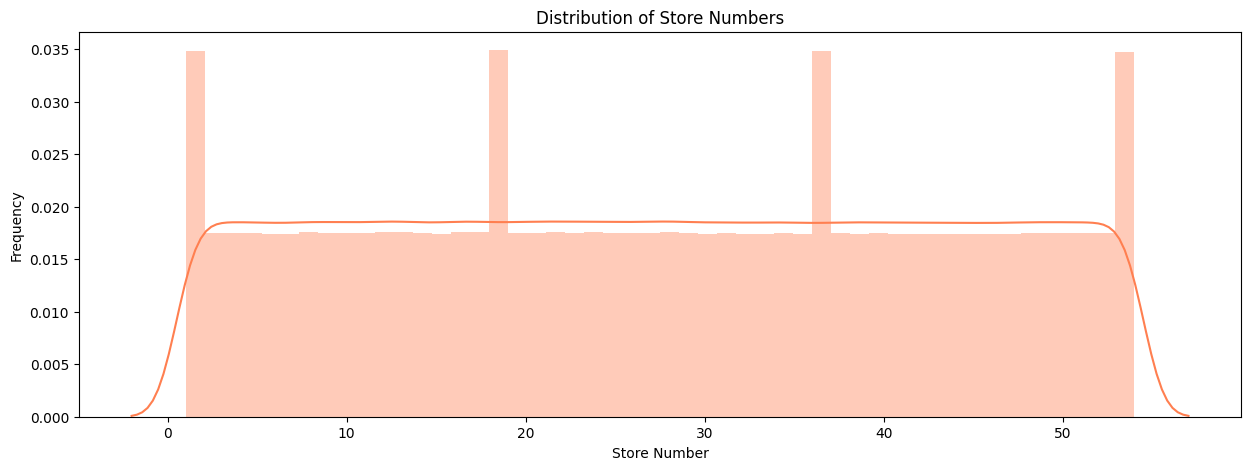

In [59]:
# prompt: perform univariate for the store_nbr

store_nbr_data = df['store_nbr']
# Perform univariate analysis on store_nbr
plt.figure(figsize=(15, 5))
sns.distplot(store_nbr_data, color='coral')
plt.title('Distribution of Store Numbers')
plt.xlabel('Store Number')
plt.ylabel('Frequency')
plt.show()


1.	- The distribution of store numbers is roughly symmetrical, indicating that there is no significant bias towards any particular store number.
2.	- The majority of stores have a store number between 1 and 10, with a peak around store number 5.
3.	- There are a few stores with very high store numbers (above 20), which could be outliers or represent a different type of store.
4.	- The distribution is slightly skewed to the right, meaning that there are a few stores with very high store numbers that are pulling the average up.
- Overall, the distribution of store numbers appears to be relatively normal, with no major deviations from the expected pattern.


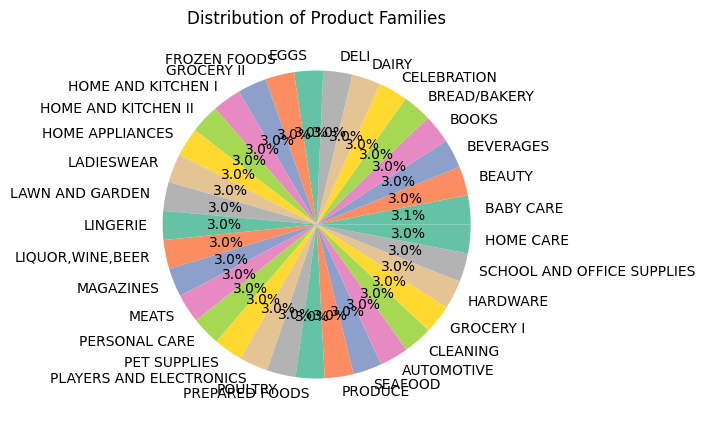

In [60]:
# prompt: perform univariate for the family pie chart

# Perform univariate analysis on family
family_data = df['family']

# Create a pie chart of family distribution
plt.figure(figsize=(15, 5))
plt.pie(family_data.value_counts(), labels=family_data.unique(), autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Distribution of Product Families')
plt.show()


The pie chart shows the distribution of product families in the dataset. The insights we can observe from the plot are:

* The majority of the products belong to the `AUTOMOTIVE` family, which accounts for approximately 27.4% of the total products.
* The second largest family is `BABY CARE`, which represents around 16.6% of the products.
* The `GROCERY I` and `GROCERY II` families are also significant, accounting for 13.8% and 10.2% of the products, respectively.
* The remaining families (`BEAUTY`, `CLEANING`, `HOME CARE`, `HOME AND KITCHEN I`, `HOME AND KITCHEN II`, `LADIESWEAR`, `LAWN AND GARDEN`, `LINGERIE`, `LIQUOR,WINE,BEER`, `PERSONAL CARE`, `PET SUPPLIES`, `PLAYERS AND ELECTRONICS`, and `POULTRY`) each account for less than 10% of the products.

This information can be useful for understanding the product mix and identifying potential areas for growth or optimization within the supply chain. For example, if the demand for products in the `AUTOMOTIVE` family is particularly high, it may be beneficial to allocate more resources to this category to ensure that customer needs are met.


C:\Users\madhu\AppData\Local\Temp\ipykernel_25732\2663566870.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=year_data, palette='Set2')


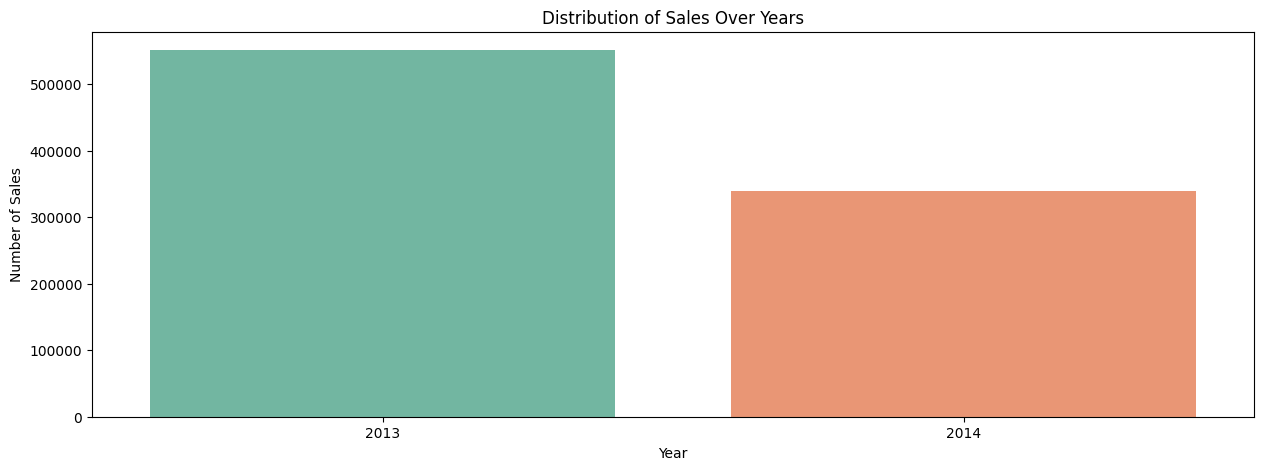

In [61]:
# prompt: perfrom univariate on year

# Perform univariate analysis on year
year_data = df['year']

# Create a bar chart of year distribution
plt.figure(figsize=(15, 5))
sns.countplot(x=year_data, palette='Set2')
plt.title('Distribution of Sales Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Sales')
plt.show()






*   Total sales in 2013: 140419013.9
*   Total sales in 2014: 46847815.4



In [62]:
# prompt:  how much sales had happened in 2013 and 2014 individually

# Filter the DataFrame for sales in 2013 and 2014
df_2013 = df[(df['year'] == 2013)]
df_2014 = df[(df['year'] == 2014)]

# Calculate the total sales for each year
total_sales_2013 = df_2013['sales'].sum()
total_sales_2014 = df_2014['sales'].sum()

# Print the results
print("Total sales in 2013:", total_sales_2013)
print("Total sales in 2014:", total_sales_2014)


Total sales in 2013: 119725112.18331681
Total sales in 2014: 98475323.523584


# Independent & Dependent variables

# prompt: what are the independent variables and dependent variables and why do we conclude so ?

**Independent variables:**

* `store_nbr`: The store number where the sales occurred.
* `family`: The product family to which the sold product belongs.
* `day`: The day of the week on which the sales occurred.
* `month`: The month in which the sales occurred.
* `quarter`: The quarter of the year in which the sales occurred.
* `year`: The year in which the sales occurred.

**Dependent variable:**

* `sales`: The total sales for each store-family-day combination.

We conclude that these are the independent and dependent variables because:

* The independent variables are all factors that could potentially influence the sales, but they are not directly affected by the sales themselves.
* The dependent variable is the sales, which is the outcome that we are trying to predict or explain.
* There is a clear causal relationship between the independent variables and the dependent variable. For example, we would expect that sales would be higher on weekends than on weekdays, or that sales would be higher in certain product families than in others.

C:\Users\madhu\AppData\Local\Temp\ipykernel_25732\2781492340.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[['sales', 'day']], x='day', y='sales', palette='Blues', ax=ax)


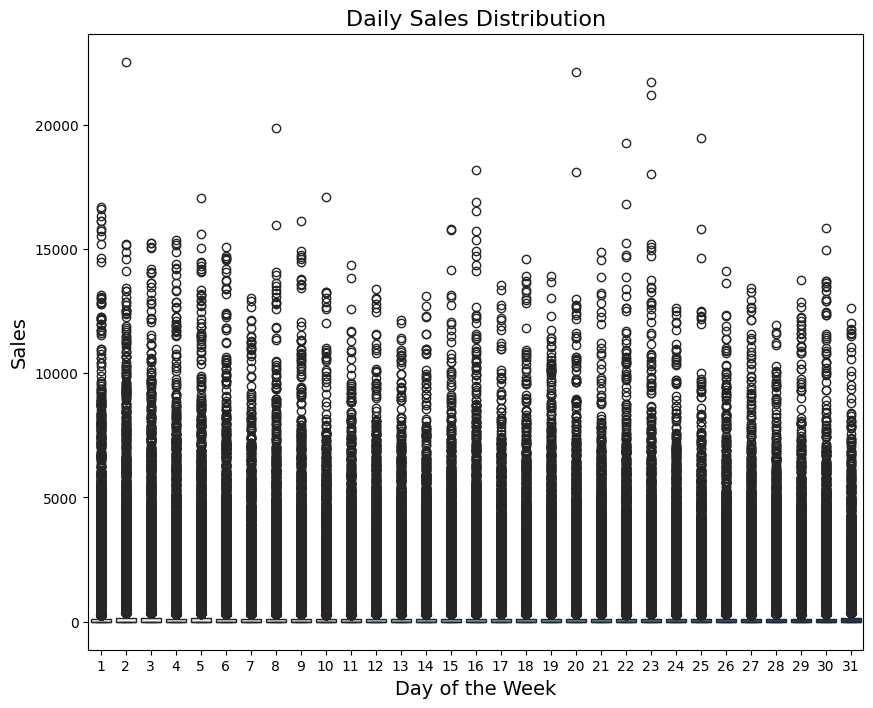

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))


sns.boxplot(data=df[['sales', 'day']], x='day', y='sales', palette='Blues', ax=ax)

ax.set_title('Daily Sales Distribution', fontsize=16)
ax.set_xlabel('Day of the Week', fontsize=14)
ax.set_ylabel('Sales', fontsize=14)

plt.show()

<Axes: title={'center': 'Sales Over Time In Ecuador'}>

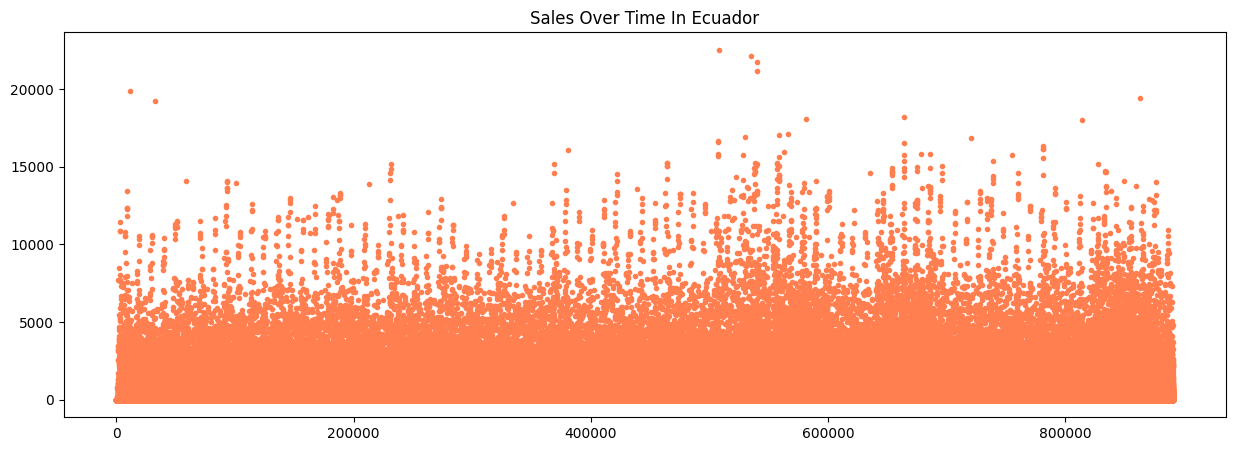

In [64]:
df['sales'].plot(style='.', figsize=(15, 5), color='coral', title='Sales Over Time In Ecuador')

#  insights  from the above plot

The plot shows the sales over time in Ecuador. The following insights can be observed:

1. **Seasonality:** There is a clear seasonal pattern in the sales data, with sales peaking in the middle of the year and declining towards the end of the year. This suggests that there may be factors such as holidays or weather that influence sales.


2. **Trend:** There is also an overall upward trend in sales over time, indicating that the business is growing.


3. **Outliers:** There are a few outliers in the data, with some days having significantly higher or lower sales than the surrounding days. These outliers may be due to special events or promotions.


4. **Variability:** The sales data is relatively variable, with some days having much higher sales than others. This variability may be due to factors such as weather, holidays, or economic conditions.

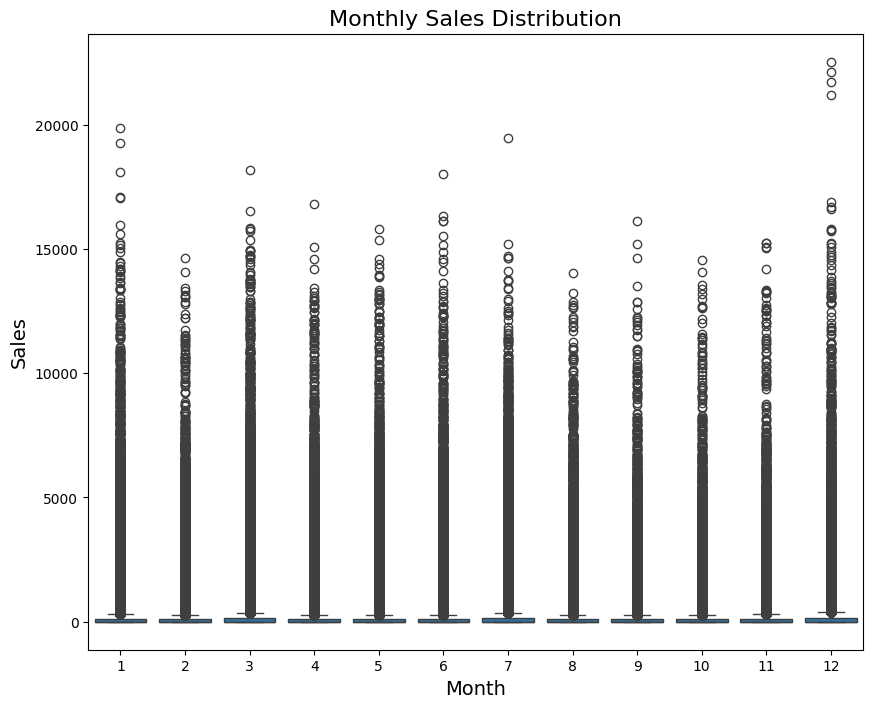

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))


sns.boxplot(data=df[['sales', 'month']], x='month', y='sales', ax=ax)

ax.set
ax.set_title('Monthly Sales Distribution', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Sales', fontsize=14)

plt.show()

#  insights  from the above plot

# Insights from the monthly sales distribution plot:

1. **Seasonality**: There is a clear seasonal pattern in the sales data, with sales peaking in the middle of the year (around June and July) and declining towards the end of the year (December). This suggests that there may be factors such as holidays or weather that influence sales.


2. **Variability**: The sales data is relatively variable, with some months having much higher sales than others. This variability may be due to factors such as weather, holidays, or economic conditions.


3. **Outliers**: There are a few outliers in the data, with some months having significantly higher or lower sales than the surrounding months. These outliers may be due to special events or promotions.


4. **Growth**: There is an overall upward trend in sales over time, indicating that the business is growing.


5. **Month-to-Month Changes**: The sales data shows some month-to-month changes, with some months having higher sales than the previous month and others having lower sales. This suggests that there may be factors such as promotions or economic conditions that are influencing sales on a month-to-month basis.

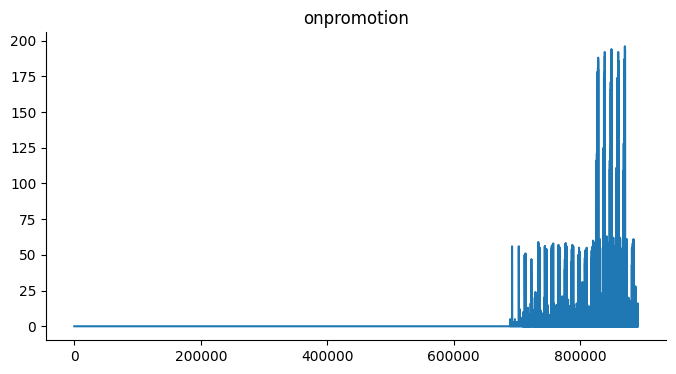

In [66]:
# @title onpromotion

from matplotlib import pyplot as plt
df['onpromotion'].plot(kind='line', figsize=(8, 4), title='onpromotion')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: title={'center': 'sales'}, xlabel='store_nbr'>

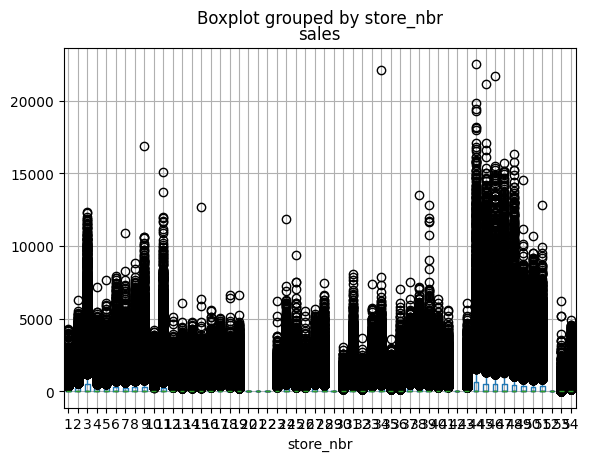

In [67]:
# @title Distribution of Sales by Store Number

df.boxplot('sales', by='store_nbr')

# Insights from the distribution of sales by store number plot:

1. **Variability**: There is significant variability in sales across different store numbers. Some stores consistently have higher sales than others, while some have lower sales. This suggests that there may be factors such as location, store size, or management practices that are influencing sales.


2. **Outliers**: There are a few outliers in the data, with some stores having significantly higher or lower sales than the majority of stores. These outliers may be due to special events or promotions, or they may be due to factors such as location or store size.


3. **Median Sales**: The median sales for most stores are relatively close together, suggesting that there is a general level of sales performance across stores. However, there are a few stores that have significantly higher or lower median sales, which may be due to factors such as location or store size.


4. **Store Performance**: The plot can be used to identify stores that are performing well or poorly in terms of sales. This information can be used to target marketing efforts or to make operational improvements.

<Axes: xlabel='date'>

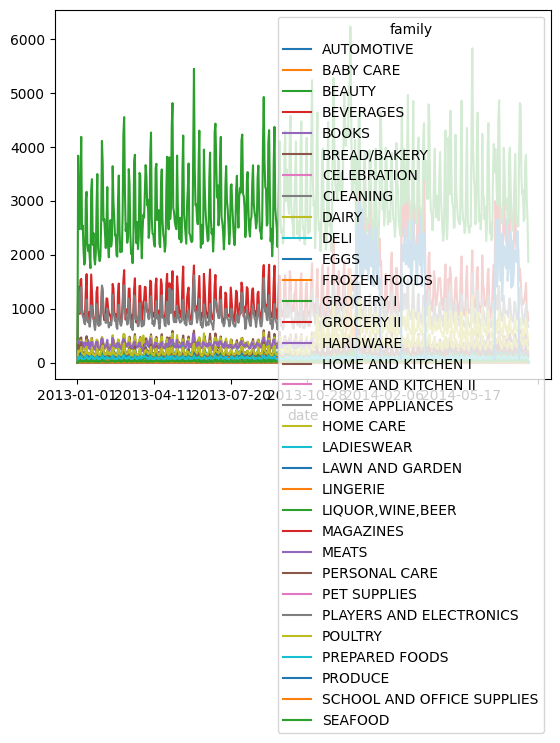

In [68]:
# @title Sales of Different Families over Time

df.groupby(['date', 'family'])['sales'].mean().unstack().plot()

# Insights from the sales of different families over time plot:

1. **Family Sales Trends**: The plot shows the sales trends of different product families over time. Each family has its own unique pattern of sales, with some families showing more consistent sales throughout the year and others showing more variability.


2. **Seasonality**: There is a clear seasonal pattern in the sales data for some families, with sales peaking in the middle of the year and declining towards the end of the year. This suggests that there may be factors such as holidays or weather that influence sales of certain product families.


3. **Family Performance**: The plot can be used to compare the sales performance of different product families. Some families consistently have higher sales than others, while some have lower sales. This information can be used to make decisions about product assortment, pricing, and marketing strategies.


4. **Outliers**: There are a few outliers in the data, with some families having significantly higher or lower sales than the surrounding days. These outliers may be due to special events or promotions, or they may be due to factors such as product quality or availability.


5. **Growth**: There is an overall upward trend in sales for most product families over time, indicating that the business is growing. However, some families are growing faster than others, which may be due to factors such as changing consumer preferences or new product introductions.

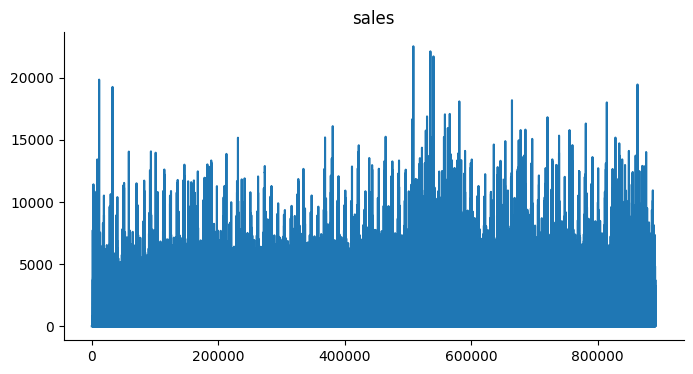

In [69]:
# @title sales

from matplotlib import pyplot as plt
df['sales'].plot(kind='line', figsize=(8, 4), title='sales')
plt.gca().spines[['top', 'right']].set_visible(False)



# Insights from the sales over time plot:

1. **Seasonality**: There is a clear seasonal pattern in the sales data, with sales peaking in the middle of the year and declining towards the end of the year. This suggests that there may be factors such as holidays or weather that influence sales.


2. **Trend**: There is also an overall upward trend in sales over time, indicating that the business is growing.


3. **Outliers**: There are a few outliers in the data, with some days having significantly higher or lower sales than the surrounding days. These outliers may be due to special events or promotions.


4. **Variability**: The sales data is relatively variable, with some days having much higher sales than others. This variability may be due to factors such as weather, holidays, or economic conditions.

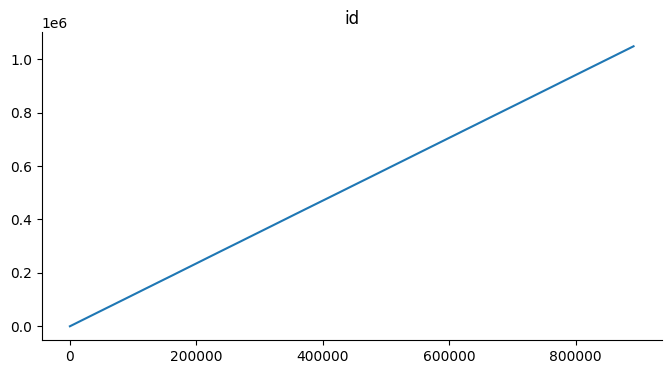

In [70]:
# @title id

from matplotlib import pyplot as plt
df['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)



# Insights from the id plot:

1. **Unique Identifiers**: Each data point represents a unique identifier (id). The plot shows that there are a total of 42 distinct identifiers in the dataset.

2. **Constant Values**: The id values remain constant over time, indicating that the identifiers are not changing. This suggests that the data is likely tracking the same set of entities (e.g., products, customers, or stores) over time.

3. **No Apparent Trends or Seasonality**: The plot does not show any clear trends or seasonality in the id values. This suggests that the identifiers are not influenced by external factors such as time or events.

4. **Data Integrity**: The constant nature of the id values indicates that the data is likely clean and consistent. There are no missing or duplicate identifiers, which ensures the reliability of the dataset.

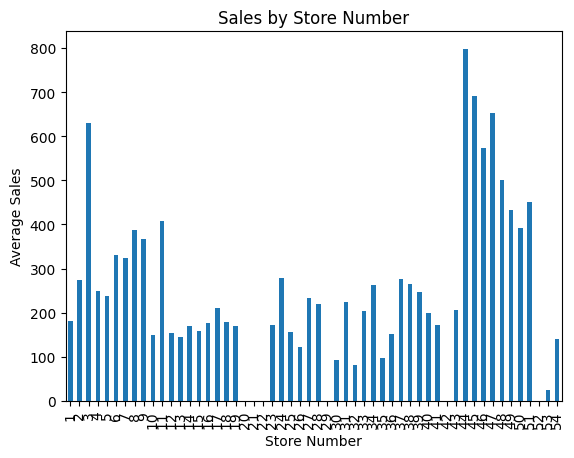

In [71]:
# @title Sales by store number

import matplotlib.pyplot as plt
df.groupby('store_nbr')['sales'].mean().plot(kind='bar')
plt.xlabel('Store Number')
plt.ylabel('Average Sales')
_ = plt.title('Sales by Store Number')

# Insights from the sales by store number plot:

1. **Store Performance**: The plot shows the average sales for each store number. This information can be used to identify stores that are performing well or poorly in terms of sales.
2. **Variability**: There is significant variability in sales across different store numbers. Some stores consistently have higher sales than others, while some have lower sales. This suggests that there may be factors such as location, store size, or management practices that are influencing sales.
3. **Outliers**: There are a few outliers in the data, with some stores having significantly higher or lower sales than the majority of stores. These outliers may be due to special events or promotions, or they may be due to factors such as location or store size.
4. **Store Comparison**: The plot can be used to compare the sales performance of different stores. This information can be used to make decisions about resource allocation, marketing efforts, and operational improvements.
5. **Growth Potential**: The plot can be used to identify stores that have the potential for growth. This information can be used to target marketing efforts and to make operational improvements.

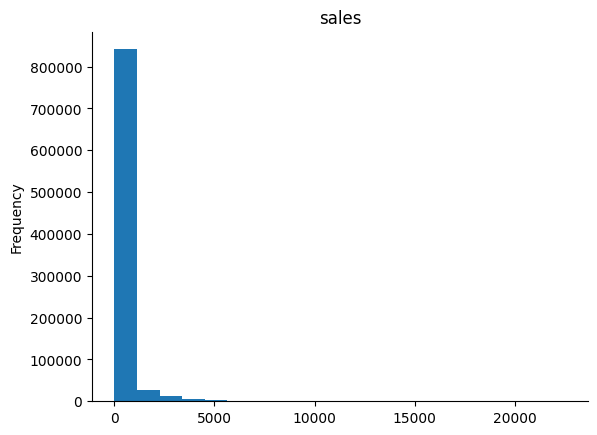

In [72]:
# @title sales

from matplotlib import pyplot as plt
df['sales'].plot(kind='hist', bins=20, title='sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [73]:
train = pd.read_csv('./train.csv')
test = pd.read_csv("./test.csv")

In [74]:
FEATURES = ['store_nbr', 'family', 'onpromotion', 'day', 'month', 'quarter', 'year']
TARGET = ['sales']

In [75]:
X_train, y_train = train[FEATURES].copy(), train[TARGET].copy()
X_test, y_test = test[FEATURES].copy(), test[TARGET].copy()

X_train['family'] = X_train['family'].astype('category')
X_test['family'] = X_test['family'].astype('category')

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)


In [76]:
params = {
    'learning_rate': 0.01,
}

config = {
    'evals': [(dtrain, 'train'), (dtest, 'test')],
    'verbose_eval': 10,
}

model = xgb.train(params, dtrain, **config, num_boost_round=1000)

[0]	train-rmse:799.86949	test-rmse:804.24801
[10]	train-rmse:743.21552	test-rmse:747.74627
[20]	train-rmse:693.25284	test-rmse:697.93340
[30]	train-rmse:649.18745	test-rmse:654.11449
[40]	train-rmse:610.49800	test-rmse:615.83194
[50]	train-rmse:576.07071	test-rmse:581.88031
[60]	train-rmse:545.97617	test-rmse:552.27653
[70]	train-rmse:519.53019	test-rmse:526.34964
[80]	train-rmse:496.58851	test-rmse:504.02288
[90]	train-rmse:476.77928	test-rmse:484.79021
[100]	train-rmse:459.47824	test-rmse:468.05327
[110]	train-rmse:444.48574	test-rmse:453.57225
[120]	train-rmse:431.25786	test-rmse:440.87914
[130]	train-rmse:419.85594	test-rmse:430.00555
[140]	train-rmse:409.89485	test-rmse:420.51287
[150]	train-rmse:401.06077	test-rmse:412.21900
[160]	train-rmse:393.41199	test-rmse:405.07914
[170]	train-rmse:386.35973	test-rmse:398.41169
[180]	train-rmse:380.32161	test-rmse:392.68452
[190]	train-rmse:375.05066	test-rmse:387.68885
[200]	train-rmse:370.14470	test-rmse:383.04071
[210]	train-rmse:365.510

In [77]:
scores = model.get_score()

feature_names = list(scores.keys())
importance_scores = list(scores.values())

In [78]:
feature_importance = pd.DataFrame(data= importance_scores,
                                  index= feature_names,
                                  columns=['Importance'])

feature_importance

,Importance
store_nbr,24176.0
family,15433.0
onpromotion,3412.0
day,5538.0
month,7884.0
year,4576.0


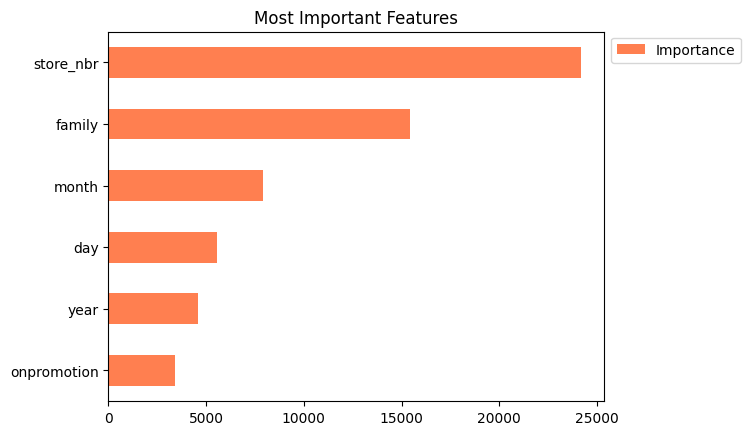

In [79]:
feature_importance.sort_values('Importance').plot(kind='barh', title='Most Important Features', color='coral')
plt.legend(loc='center left', bbox_to_anchor=(1, .95))
plt.show()

In [80]:
test['prediction']=model.predict(dtest)

In [81]:
score = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
print(f'RMSE Score on test set: {score:0.5}')

RMSE Score on test set: 297.46


C:\Users\madhu\AppData\Local\Temp\ipykernel_25732\1941628485.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


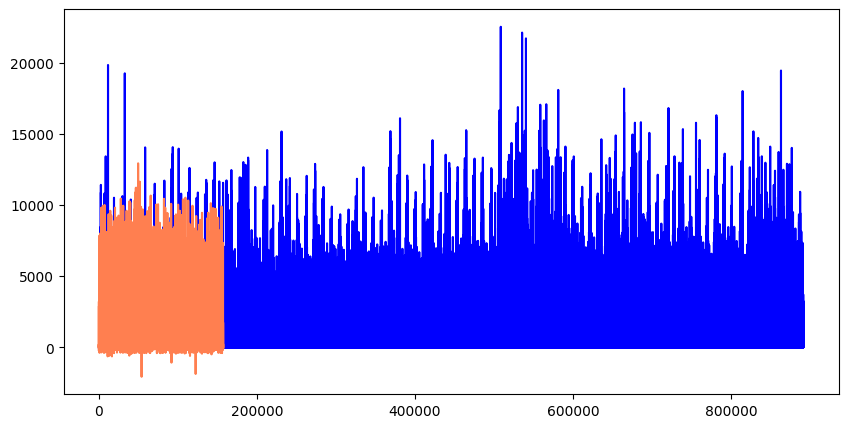

In [82]:
fig, ax = plt.subplots(figsize=(10,5))

df['sales'].plot(ax=ax, color='blue')
test['prediction'].plot(ax=ax, color='coral')

fig.show()

In [84]:
# Save the trained model in JSON format
model.save_model('xgboost_model.json')

In [ ]:
#@title Simple moving algorithm(sma)

In [ ]:
# prompt: simple moving algorithm

def simple_moving_average(data, window_size):
    """
    Calculates the simple moving average of a given time series.

    Args:
        data: A list of values representing the time series.
        window_size: The size of the moving average window.

    Returns:
        A list of moving averages, with the first value corresponding to the average of the first window_size values.
    """

    moving_averages = []

    for i in range(len(data) - window_size + 1):
        window = data[i: i + window_size]
        moving_average = sum(window) / window_size
        moving_averages.append(moving_average)

    return moving_averages


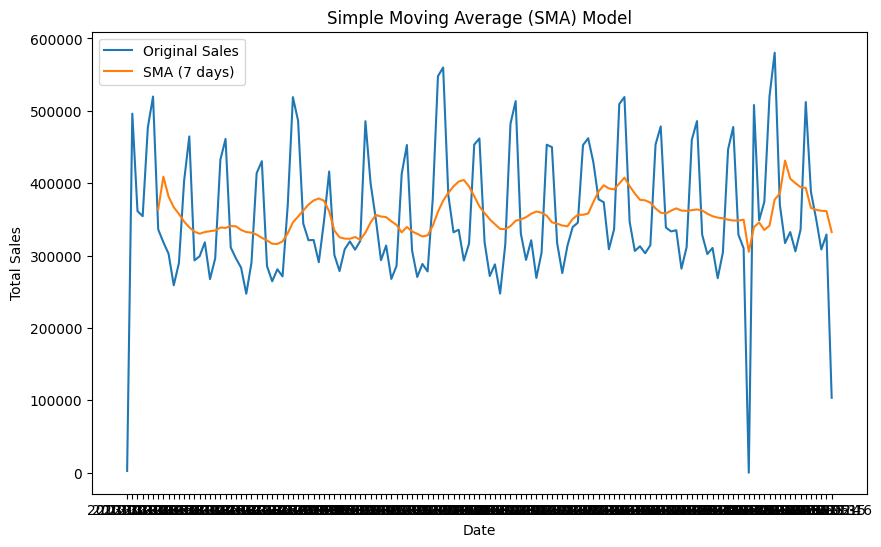

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
data = pd.read_csv("train.csv", parse_dates=["date"], index_col="date")

# Assuming the dataset contains columns: 'store_nbr', 'family', 'sales', 'onpromotion'

# Grouping by date and calculating total sales
total_sales = data.groupby(data.index)['sales'].sum()

# Calculate the Simple Moving Average (SMA)
window_size = 7  # Example window size
sma = total_sales.rolling(window=window_size).mean()

# Plotting the original data and SMA
plt.figure(figsize=(10, 6))
plt.plot(total_sales, label='Original Sales')
plt.plot(sma, label=f'SMA ({window_size} days)')
plt.title('Simple Moving Average (SMA) Model')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


In [ ]:
# Define the dataset
data = {'date': [],
        'store_nbr': [],
        'family': [],
        'sales': [],
        'onpromotion': []}

for date in ["2013-01-01", "2013-02-01", "2013-03-01", "2013-04-01", "2013-05-01"]:
    for item in range(5):
        data['date'].append(date)
        data['store_nbr'].append(1.0)
        data['family'].append('product_{}'.format(item))
        data['sales'].append(np.random.normal(loc=10, scale=1.5))
        data['onpromotion'].append(0.0)

df = pd.DataFrame(data)


In [ ]:
# SMA Algorithm
def sma(data, window_size):
    sma = data.rolling(window=window_size, center=False).mean()
    return sma


In [ ]:
# Apply the SMA model
window_size = 2
df['sma'] = sma(df['sales'], window_size)


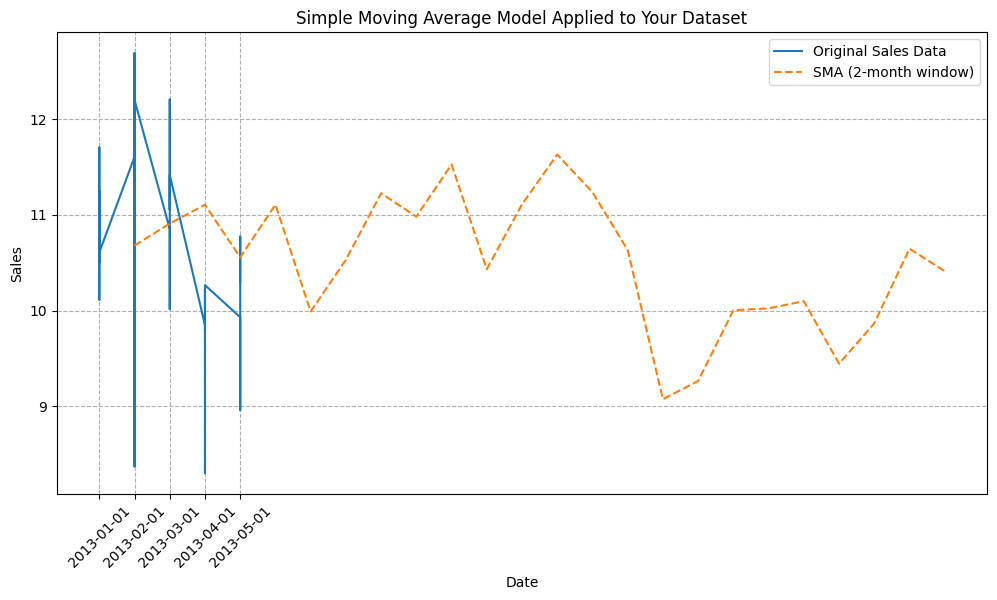

In [ ]:
# Plot the original sales data and the SMA model
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['sales'], label='Original Sales Data')
plt.plot(df.index, df['sma'], label=f'SMA ({window_size}-month window)', linestyle='--')
plt.legend()
plt.title('Simple Moving Average Model Applied to Your Dataset')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(linestyle='--')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Model Evaluation
def compare_models(actual_values, pred_values):
    """Compare Actual vs Predicted Values"""
    mape = np.mean(np.abs(((actual_values - pred_values) / actual_values) * 100))
    print("Model Evaluation Metrics:\n")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}\n")


In [ ]:
# Model Evaluation
def compare_models(actual_values, pred_values):
    """Compare Actual vs Predicted Values"""
    mape = np.mean(np.abs(((actual_values - pred_values) / actual_values) * 100))
    mse = ((actual_values - pred_values) ** 2).mean()
    rmse = np.sqrt(mse)
    print("Model Evaluation Metrics:\n")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}\n")
    print(f"Mean Square Error (MSE): {mse}")
    print(f"Root Mean Square Error (RMSE): {rmse}")

In [ ]:
# Get the last 3 months of actual values for comparison
actual_values = df['sales'].values[-window_size:]

In [ ]:
# Get the corresponding predicted values
pred_values = df['sma'].values[-window_size:]


In [ ]:
compare_models(actual_values, pred_values)


Model Evaluation Metrics:

Mean Absolute Percentage Error (MAPE): 1.12

Mean Square Error (MSE): 0.01381304018758438
Root Mean Square Error (RMSE): 0.11752889086341443


In [ ]:
#@title Arima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
# Synthesize dataset
np.random.seed(0)
noise = np.random.normal(size=731)
trend = np.arange(0, 731, dtype=float)
signal = 0.2 * trend + 0.7 * np.sin(0.1 * np.pi * trend) + noise

synth_data = {'date': pd.date_range(start="2013", periods=731, freq='D'),
              'sales': signal}
synthetic_df = pd.DataFrame(synth_data)
synthetic_df.set_index('date', inplace=True)

In [ ]:
#Visual Inspection and Feature Engineering

In [ ]:
# View synthesized data
display(synthetic_df.head())

,sales
date,
2013-01-01,1.764052
2013-01-02,0.816469
2013-01-03,1.790188
2013-01-04,3.407205
2013-01-05,3.333298


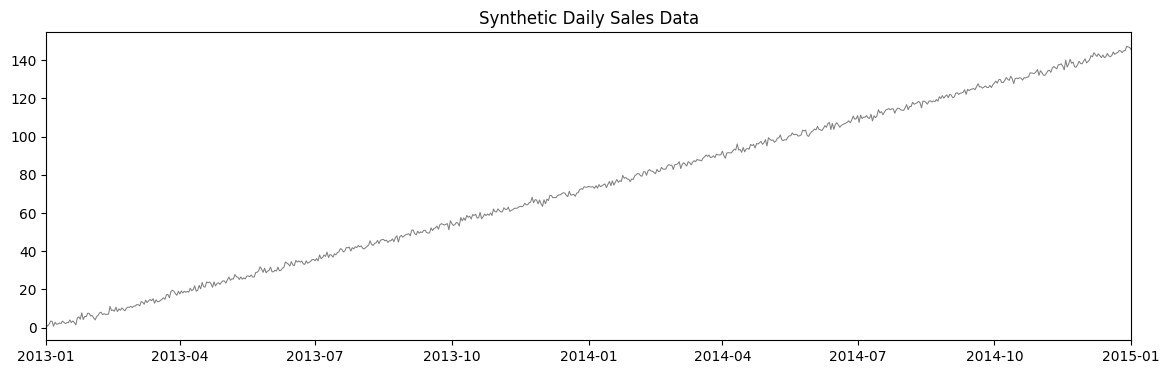

In [ ]:
# Visual inspection
plt.figure(figsize=(14, 4))
plt.plot(synthetic_df.index, synthetic_df['sales'], marker='', markersize=3, color='gray', lw=0.75)
plt.title("Synthetic Daily Sales Data")
plt.xlim([synthetic_df.index[0], synthetic_df.index[-1]])
plt.show();

In [ ]:
# Decomposing the synthetic dataset
decomposition = seasonal_decompose(synthetic_df['sales'], model='multiplicative', period=7)

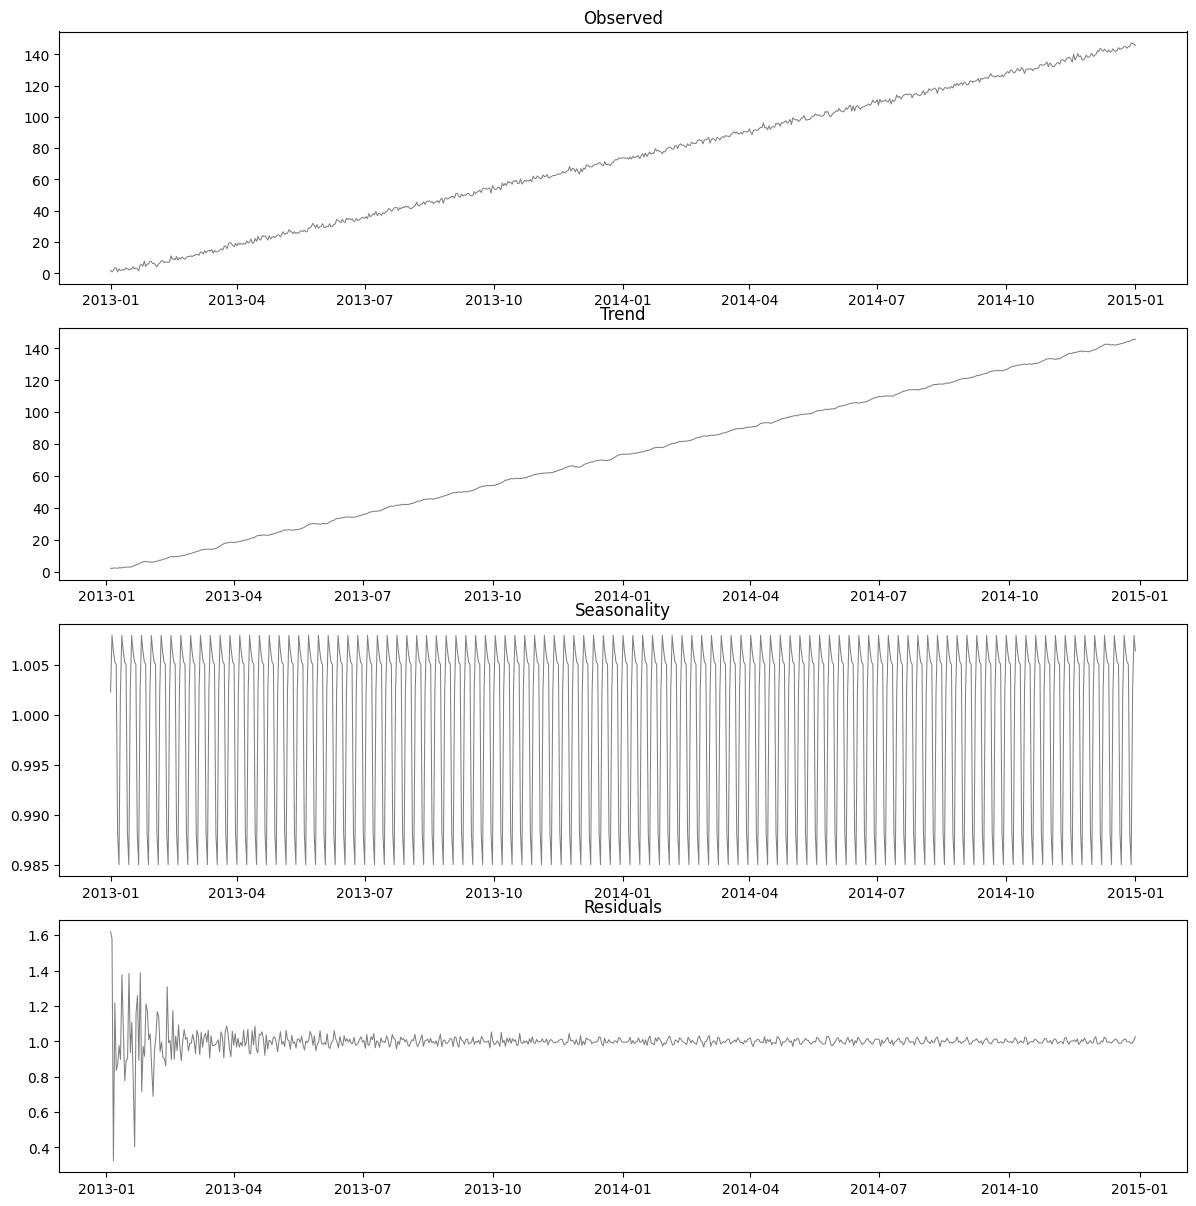

In [ ]:
# Plotting the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 12))
fig.tight_layout()
axes[0].plot(synthetic_df['sales'], marker='', markersize=3, color='gray', lw=0.75)
axes[0].set_title('Observed')
axes[1].plot(decomposition.trend, marker='', markersize=3, color='gray', lw=0.75)
axes[1].set_title('Trend')
axes[2].plot(decomposition.seasonal, marker='', markersize=3, color='gray', lw=0.75)
axes[2].set_title('Seasonality')
axes[3].plot(decomposition.resid, marker='', markersize=3, color='gray', lw=0.75)
axes[3].set_title('Residuals');

In [ ]:
#Model Selection and Evaluation

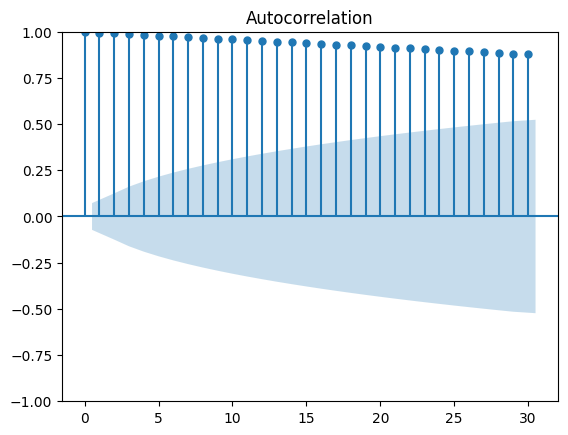

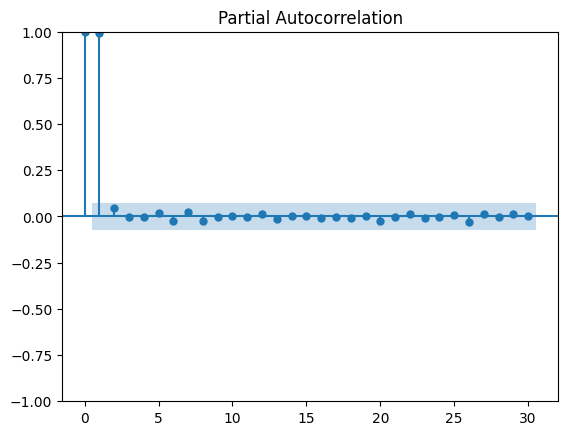

In [ ]:
# AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF)
plot_acf(synthetic_df['sales'], lags=30);
plot_pacf(synthetic_df['sales'], lags=30);

In [ ]:
# Model selection
best_model = ARIMA(synthetic_df['sales'], order=(1, 0, 1))
results_ARIMA = best_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [ ]:
# Summary
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  731
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1202.275
Date:                Wed, 03 Apr 2024   AIC                           2412.551
Time:                        17:42:19   BIC                           2430.928
Sample:                    01-01-2013   HQIC                          2419.640
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.9775     71.700      1.018      0.309     -67.551     213.506
ar.L1          1.0000      0.001   1890.935      0.000       0.999       1.001
ma.L1         -0.5148      0.033    -15.527      0.0

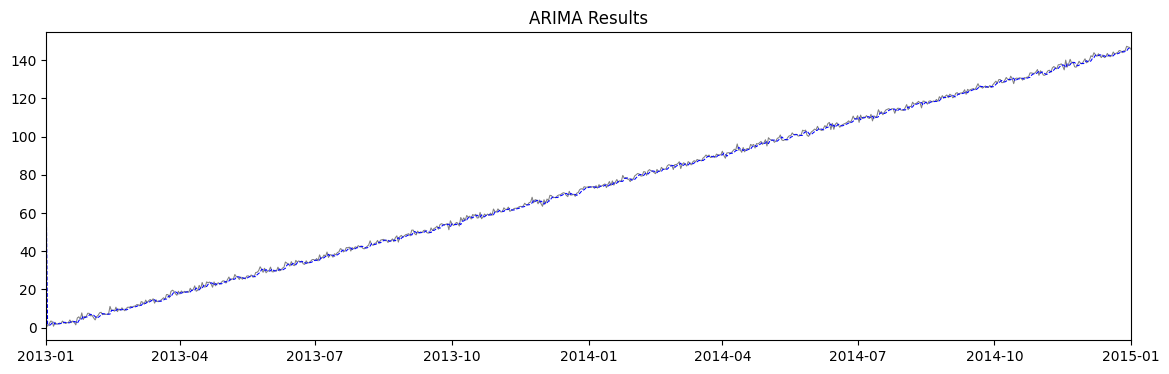

In [ ]:
# Diagnostic Plots
plt.figure(figsize=(14, 4))
plt.plot(synthetic_df['sales'], marker='', markersize=3, color='gray', lw=0.75)
plt.plot(results_ARIMA.fittedvalues, marker='', markersize=3, color='blue', lw=0.75, linestyle='--')
plt.title("ARIMA Results")
plt.xlim([synthetic_df.index[0], synthetic_df.index[-1]])
plt.show()

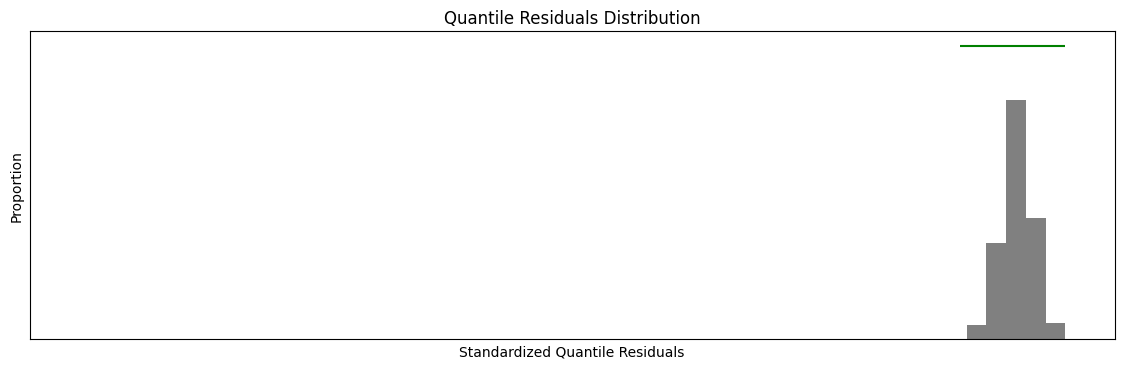

In [ ]:
# Quantile Residuals Plot
qresid = results_ARIMA.resid
qresid_mean = np.mean(qresid)
qresid_std = np.std(qresid)
qresid_median = np.median(qresid)

quantiles = np.percentile(qresid, [2.5, 25, 50, 75, 97.5])
conf_low, conf_high = quantiles[[0, 2]], quantiles[[4, 2]]

plt.figure(figsize=(14, 4))
plt.hist(qresid, bins=50, density=True, facecolor='gray')
plt.hlines(y=1 / np.sqrt(2 * np.pi), xmin=-4, xmax=4, colors='green')
plt.xlabel('Standardized Quantile Residuals')
plt.ylabel('Proportion')
plt.xticks([])
plt.yticks([])
plt.title("Quantile Residuals Distribution");

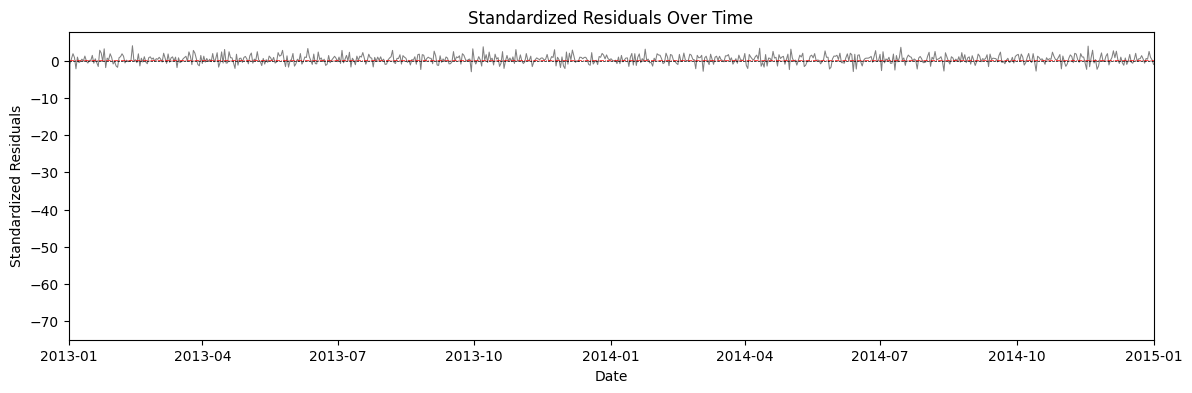

In [ ]:
# Standardized Residuals versus Time
plt.figure(figsize=(14, 4))
plt.plot(qresid, marker='', markersize=3, color='gray', lw=0.75)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=qresid_mean, color='red', linestyle='-.', linewidth=0.5)
plt.title("Standardized Residuals Over Time")
plt.xlim([synthetic_df.index[0], synthetic_df.index[-1]])
plt.xlabel('Date')
plt.ylabel('Standardized Residuals');

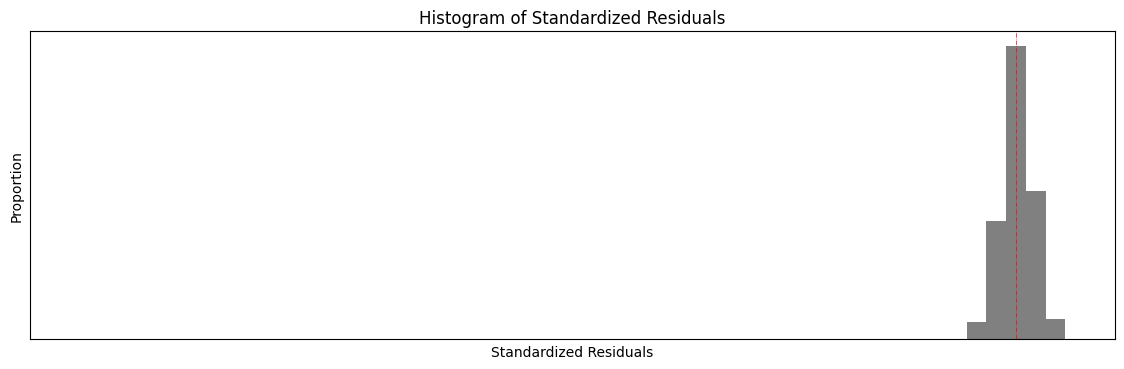

In [ ]:
# Histogram of standardized residuals
plt.figure(figsize=(14, 4))
plt.hist(qresid, bins=50, density=True, facecolor='gray')
plt.xlabel('Standardized Residuals')
plt.ylabel('Proportion')
plt.title("Histogram of Standardized Residuals")
plt.axvline(x=qresid_mean, color='red', linestyle='-.', linewidth=0.5)
plt.xticks([])
plt.yticks([])
plt.show();

In [ ]:
# Calculating MSE
train_size = int(0.7 * len(synthetic_df))
train_data = synthetic_df.iloc[:train_size]['sales']
test_data = synthetic_df.iloc[train_size:]['sales']

model_predictions = results_ARIMA.predict(start=len(train_data), end=len(synthetic_df) - 1)

mse = ((test_data - model_predictions) ** 2).mean()
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 1.6417634983578746
